<a href="https://colab.research.google.com/github/aem210/computer-vision-using-deep-learning/blob/main/7_VGG16_with_YouTube_Excavator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import cv2
import os
import numpy as np
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.preprocessing.image import img_to_array
from keras.optimizers import SGD

import math   # for mathematical operations
import matplotlib.pyplot as plt    # for plotting the images
%matplotlib inline
import pandas as pd
from keras.preprocessing import image   # for preprocessing the images
from keras.utils import np_utils
from skimage.transform import resize   # for resizing images
from sklearn.model_selection import train_test_split
from glob import glob
from tqdm import tqdm
import os

Load the files 

In [2]:
data_dir_path = "/content/drive/MyDrive"
data_set_name = 'train'

Get the base model 

In [3]:
# creating the base model of pre-trained VGG16 model
base_model = VGG16(weights='imagenet', include_top=False)
base_model.compile(optimizer=SGD(), loss='categorical_crossentropy', metrics=['accuracy'])


In [4]:
#function from https://github.com/jibinmathew69/VideoClassifier-CNNLSTM/blob/684cce5c2a7c1005d930d8fca6ced5f7ae776b0b/keras_video_classifier/library/utility/frame_extractors/vgg16_feature_extractor.py 
#this function extracts the features of the video by predicting using VGG16 
def extract_vgg16_features(model, video_input_file_path, feature_output_file_path):
    if os.path.exists(feature_output_file_path):
        return np.load(feature_output_file_path)
    count = 0
    print('Extracting frames from video: ', video_input_file_path)
    vidcap = cv2.VideoCapture(video_input_file_path)
    success, image = vidcap.read()
    features = []
    success = True
    while success:
        vidcap.set(cv2.CAP_PROP_POS_MSEC, (count * 100))  # added this line
        success, image = vidcap.read()
        # print('Read a new frame: ', success)
        if success:
            img = cv2.resize(image, (224, 224), interpolation=cv2.INTER_AREA)
            input = img_to_array(img)
            input = np.expand_dims(input, axis=0)
            input = preprocess_input(input)
            feature = model.predict(input).ravel()
            features.append(feature)
            count = count + 1
    unscaled_features = np.array(features)
    np.save(feature_output_file_path, unscaled_features)
    return unscaled_features


In [5]:
#function from https://github.com/jibinmathew69/VideoClassifier-CNNLSTM/blob/684cce5c2a7c1005d930d8fca6ced5f7ae776b0b/keras_video_classifier/library/utility/frame_extractors/vgg16_feature_extractor.py 
#this function will scan and extract the features and the labels 
def scan_and_extract_vgg16_features(data_dir_path, output_dir_path, model=base_model, data_set_name=data_set_name):
    if data_set_name is None:
        data_set_name = 'train'

    input_data_dir_path = data_dir_path + '/' + data_set_name
    output_feature_data_dir_path = data_dir_path + '/' + output_dir_path

    if model is None:
        model = VGG16(include_top=True, weights='imagenet')
        model.compile(optimizer=SGD(), loss='categorical_crossentropy', metrics=['accuracy'])
    
    if not os.path.exists(output_feature_data_dir_path):
        os.makedirs(output_feature_data_dir_path)

    y_samples = []
    x_samples = []

    dir_count = 0
    for f in os.listdir(input_data_dir_path):
        file_path = input_data_dir_path + os.path.sep + f
        print(file_path)
        if not os.path.isfile(file_path):
            output_dir_name = f
            output_dir_path = output_feature_data_dir_path + os.path.sep + output_dir_name
            #print(output_dir_path)
            if not os.path.exists(output_dir_path):
                os.makedirs(output_dir_path)
            dir_count += 1
            for ff in os.listdir(file_path):
                video_file_path = file_path + os.path.sep + ff
                output_feature_file_path = output_dir_path + os.path.sep + ff.split('.')[0] + '.npy'
                #print(output_feature_file_path)
                x = extract_vgg16_features(base_model, video_file_path, output_feature_file_path)
                y = f
                y_samples.append(y)
                x_samples.append(x)

        if dir_count == MAX_NB_CLASSES:
            break

    return x_samples, y_samples

In [6]:
#make an output directory to put the outputs in
output_dir_path = data_set_name + 'VGG16_Features'
os.makedirs(output_dir_path, exist_ok = True)


In [7]:
#Extract the features and the labels from each mp4 file 
MAX_NB_CLASSES = 4

x_samples, y_samples = scan_and_extract_vgg16_features(data_dir_path, output_dir_path, model=base_model, data_set_name='train')



/content/drive/MyDrive/train/Dumping
Extracting frames from video:  /content/drive/MyDrive/train/Dumping/Dumping_2.mp4
Extracting frames from video:  /content/drive/MyDrive/train/Dumping/Dumping_1.mp4
Extracting frames from video:  /content/drive/MyDrive/train/Dumping/Dumping_4.mp4
Extracting frames from video:  /content/drive/MyDrive/train/Dumping/Dumping_5.mp4
Extracting frames from video:  /content/drive/MyDrive/train/Dumping/Dumping_6.mp4
Extracting frames from video:  /content/drive/MyDrive/train/Dumping/Dumping_8.mp4
Extracting frames from video:  /content/drive/MyDrive/train/Dumping/Dumping_9.mp4
Extracting frames from video:  /content/drive/MyDrive/train/Dumping/Dumping_10.mp4
Extracting frames from video:  /content/drive/MyDrive/train/Dumping/Dumping_11.mp4
Extracting frames from video:  /content/drive/MyDrive/train/Dumping/Dumping_13.mp4
Extracting frames from video:  /content/drive/MyDrive/train/Dumping/Dumping_14.mp4
Extracting frames from video:  /content/drive/MyDrive/tra

In [33]:
x_samples[0].shape[1]

25088

In [36]:
#process the image data so that it can be split and used in the models 
#this block of code takes the average number of frames in the samples and corrects all hte clips so that all clips have the same number of frames (images)
#this will mean that the input shape will be consistent across all the videos when feeding into the LSTM 
max_frames = 0
num_input_tokens = x_samples[0].shape[1]
frames_list = []
for x in x_samples:
    frames = x.shape[0]
    frames_list.append(frames)
    max_frames = max(frames, max_frames)
expected_frames = int(np.mean(frames_list))
print('max frames: ', max_frames)
print('expected frames: ', expected_frames)

for i in range(len(x_samples)):
    x = x_samples[i]
    frames = x.shape[0]
    if frames > expected_frames:
        x = x[0:expected_frames, :]
        x_samples[i] = x
    elif frames < expected_frames:
        temp = np.zeros(shape=(expected_frames, x.shape[1]))
        temp[0:frames, :] = x
        x_samples[i] = temp




max frames:  310
expected frames:  54


In [38]:
#convert the samples into array of correct size (sammples, timesteps, features)
x_features = np.array(x_samples)

In [47]:
x_features[1].shape

(54, 25088)

In [41]:
#process the labels 
labels = dict()
for y in y_samples:
    if y not in labels:
        labels[y] = len(labels)
print(labels)
for i in range(len(y_samples)):
    y_samples[i] = labels[y_samples[i]]

nb_classes = len(labels)

y_samples = np_utils.to_categorical(y_samples, nb_classes)

{'Dumping': 0, 'Hauling': 1, 'Digging': 2, 'Swinging': 3}


In [43]:
# creating the training and validation set
x_train, x_test, y_train, y_test = train_test_split(x_features, y_samples, random_state=42, test_size=0.2, stratify = y_samples)

In [45]:
y_train.shape

(58, 4)

In [50]:
# normalizing the pixel values
max = x_train.max()
x_train = x_train/max
x_test = x_test/max


In [52]:
x_train.shape[1]

54

#Create Model 


In [54]:
from keras.layers import Dense, Activation, Dropout, Bidirectional
from keras.layers.recurrent import LSTM
from keras.models import Sequential
from keras.applications.vgg16 import VGG16
from keras.optimizers import SGD
from keras.optimizers import Adam
from keras import backend as K
from keras.utils import np_utils
from sklearn.model_selection import train_test_split
from keras.callbacks import ModelCheckpoint
import os
import numpy as np

In [55]:
#create model 
model = Sequential()
model.add(LSTM(256, input_shape=(x_train.shape[1], x_train.shape[2]), return_sequences=False, dropout=0.5))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(nb_classes))
model.add(Activation('softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 256)               25953280  
_________________________________________________________________
dense (Dense)                (None, 512)               131584    
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 2052      
_________________________________________________________________
activation (Activation)      (None, 4)                 0         
Total params: 26,086,916
Trainable params: 26,086,916
Non-trainable params: 0
_________________________________________________________________


In [56]:
#compile model 
model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

In [57]:
# defining a function to save the weights of best model
from keras.callbacks import ModelCheckpoint
mcp_save = ModelCheckpoint('VG16_LSTM_weight.hdf5', save_best_only=True, monitor='val_loss', mode='min')

#Train the model 

In [58]:
history = model.fit(x_train, y_train, epochs=200, validation_data=(x_test, y_test), shuffle=True, callbacks=[mcp_save], batch_size=4)


Epoch 1/200
15/15 [==============================] - 24s 464ms/step - loss: 1.6290 - accuracy: 0.1518 - val_loss: 1.2553 - val_accuracy: 0.2667
Epoch 2/200
15/15 [==============================] - 6s 384ms/step - loss: 1.2962 - accuracy: 0.3703 - val_loss: 1.2977 - val_accuracy: 0.4667
Epoch 3/200
15/15 [==============================] - 6s 385ms/step - loss: 1.2547 - accuracy: 0.4329 - val_loss: 1.3279 - val_accuracy: 0.4667
Epoch 4/200
15/15 [==============================] - 6s 386ms/step - loss: 1.2391 - accuracy: 0.4053 - val_loss: 1.1292 - val_accuracy: 0.5333
Epoch 5/200
15/15 [==============================] - 6s 398ms/step - loss: 1.1588 - accuracy: 0.3993 - val_loss: 1.0893 - val_accuracy: 0.5333
Epoch 6/200
15/15 [==============================] - 6s 387ms/step - loss: 1.0036 - accuracy: 0.5516 - val_loss: 1.1983 - val_accuracy: 0.5333
Epoch 7/200
15/15 [==============================] - 6s 393ms/step - loss: 1.1144 - accuracy: 0.5102 - val_loss: 1.1250 - val_accuracy: 0.533

Save Model

In [68]:
import datetime as dt

#save the whole model 
#save the model 
# Creating a useful name for our model, incase you're saving multiple models (OPTIONAL)
date_time_format = '%Y_%m_%d__%H_%M_%S'
current_date_time_dt = dt.datetime.now()
current_date_time_string = dt.datetime.strftime(current_date_time_dt, date_time_format)
validation_loss = history.history['val_loss']
validation_accuracy = history.history['val_accuracy']
model_name = f'Model___Date_Time_{current_date_time_string}.h5'

# Saving your Model
model.save(model_name)

#Plot history

In [69]:
def plot_metric(metric_name_1, metric_name_2, plot_name):
  # Get Metric values using metric names as identifiers
  metric_value_1 = history.history[metric_name_1]
  metric_value_2 = history.history[metric_name_2]

  # Constructing a range object which will be used as time 
  epochs = range(len(metric_value_1))
  
  # Plotting the Graph
  plt.plot(epochs, metric_value_1, 'blue', label = metric_name_1)
  plt.plot(epochs, metric_value_2, 'red', label = metric_name_2)
  
  # Adding title to the plot
  plt.title(str(plot_name))

  # Adding legend to the plot
  plt.legend()

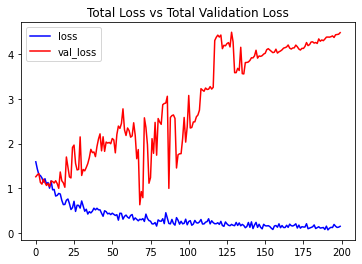

In [70]:
plot_metric('loss', 'val_loss', 'Total Loss vs Total Validation Loss')


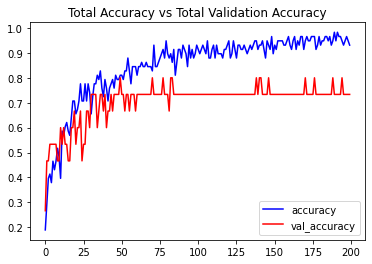

In [71]:
plot_metric('accuracy', 'val_accuracy', 'Total Accuracy vs Total Validation Accuracy')


#predict on a new video 

In [72]:
#function to extract frames live 
def extract_vgg16_features_live(model, video_input_file_path):
    print('Extracting frames from video: ', video_input_file_path)
    vidcap = cv2.VideoCapture(video_input_file_path)
    success, image = vidcap.read()
    features = []
    success = True
    count = 0
    while success:
        vidcap.set(cv2.CAP_PROP_POS_MSEC, (count * 1000))  # added this line
        success, image = vidcap.read()
        # print('Read a new frame: ', success)
        if success:
            img = cv2.resize(image, (224, 224), interpolation=cv2.INTER_AREA)
            input = img_to_array(img)
            input = np.expand_dims(input, axis=0)
            input = preprocess_input(input)
            feature = model.predict(input).ravel()
            features.append(feature)
            count = count + 1
    unscaled_features = np.array(features)
    return unscaled_features

In [90]:
#function to predict on the video that had features extracted in 'extract_vg_features_live' func
def predict_on_video(base_model, model, video_file_path):
    x = extract_vgg16_features_live(base_model, video_file_path)
    frames = x.shape[0]
    if frames > expected_frames:
        x = x[0:expected_frames, :]
    elif frames < expected_frames:
        temp = np.zeros(shape=(expected_frames, x.shape[1]))
        temp[0:frames, :] = x
        x = temp
    predicted_class = np.argmax(model.predict(np.array([x]))[0])
    predicted_label = labels_idx2word[predicted_class]
    return predicted_label


In [88]:
#definition for changing an index 
labels_idx2word = dict([(idx, word) for word, idx in labels.items()])



In [99]:
#predict on a video 
video_path = '/content/drive/MyDrive/test/Digging/Digging_14.mp4'
label = predict_on_video(base_model=base_model, model=model, video_file_path=video_path )

Extracting frames from video:  /content/drive/MyDrive/test/Digging/Digging_14.mp4


In [100]:
print(label)

Digging


In [101]:
#this function will predict on all the test data 
def predict_on_test_videos(data_dir_path, base_model, model, data_set_name='test'):

    input_data_dir_path = data_dir_path + '/' + data_set_name

    test_labels = []
    predicted_labels = []

    dir_count = 0
    for f in os.listdir(input_data_dir_path):
        file_path = input_data_dir_path + os.path.sep + f
        print(file_path)
        for ff in os.listdir(file_path):
            video_file_path = file_path + os.path.sep + ff
            #print(output_feature_file_path)
            x = predict_on_video(base_model=base_model, model=model, video_file_path=video_file_path )
            y = f
            test_labels.append(y)
            predicted_labels.append(x)

    return test_labels, predicted_labels

In [102]:
test_labels, predicted_labels = predict_on_test_videos(data_dir_path, base_model, model, data_set_name='test')

/content/drive/MyDrive/test/Hauling
Extracting frames from video:  /content/drive/MyDrive/test/Hauling/Hauling_4.mp4
Extracting frames from video:  /content/drive/MyDrive/test/Hauling/Hauling_1.mp4
Extracting frames from video:  /content/drive/MyDrive/test/Hauling/Hauling_8.mp4
Extracting frames from video:  /content/drive/MyDrive/test/Hauling/Hauling_14.mp4
Extracting frames from video:  /content/drive/MyDrive/test/Hauling/Hauling_19.mp4
/content/drive/MyDrive/test/Dumping
Extracting frames from video:  /content/drive/MyDrive/test/Dumping/Dumping_3.mp4
Extracting frames from video:  /content/drive/MyDrive/test/Dumping/Dumping_7.mp4
Extracting frames from video:  /content/drive/MyDrive/test/Dumping/Dumping_12.mp4
Extracting frames from video:  /content/drive/MyDrive/test/Dumping/Dumping_18.mp4
Extracting frames from video:  /content/drive/MyDrive/test/Dumping/Dumping_24.mp4
/content/drive/MyDrive/test/Digging
Extracting frames from video:  /content/drive/MyDrive/test/Digging/Digging_1.

In [103]:
print(predicted_labels)

['Digging', 'Dumping', 'Dumping', 'Digging', 'Dumping', 'Dumping', 'Dumping', 'Dumping', 'Digging', 'Dumping', 'Dumping', 'Digging', 'Digging', 'Digging', 'Dumping', 'Dumping', 'Digging', 'Dumping', 'Dumping']


In [104]:
print(test_labels)

['Hauling', 'Hauling', 'Hauling', 'Hauling', 'Hauling', 'Dumping', 'Dumping', 'Dumping', 'Dumping', 'Dumping', 'Digging', 'Digging', 'Digging', 'Digging', 'Digging', 'Swinging', 'Swinging', 'Swinging', 'Swinging']


In [105]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 256)               25953280  
_________________________________________________________________
dense (Dense)                (None, 512)               131584    
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 2052      
_________________________________________________________________
activation (Activation)      (None, 4)                 0         
Total params: 26,086,916
Trainable params: 26,086,916
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.load_weights("weight.hdf5")
